In [ ]:
import pandas as pd
import numpy as np

# do a preliminary read of the csv and attempt to parse column types
dev_2017_pre = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'])

print(dev_2017_pre)

# since the quantity column is parsed generically as object, 
# it likely includes some anomalous (e.g. missing) values 
print(dev_2017_pre.dtypes)

In [ ]:
# rows indices 13594, 13595, 13596 are missing values for deviation
print(dev_2017_pre[dev_2017_pre['quantity']=='na'])


In [ ]:
# since only few rows contain missing quantity values, 
# we just load the csv again skipping them
# use 
dev_2017 = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'], skiprows=range(13595,13598))

# check that rows with missing quantity values have been removed
# print(dev_2017[dev_2017['quantity']=='na'])

# another ignored option: filter the loaded dataframe directly.
# however, here we would need to replace commas
# by periods as decimal separators in order to be
# able to parse them as floats

# dev_2017 = dev_2017_pre.loc[dev_2017_pre['quantity']!='na']

In [ ]:
# the column types are now correctly parsed
dev_2017.dtypes

In [ ]:
# there seem to be some extreme outliers
dev_2017.describe()

In [ ]:
# look for the timestamps corresponding to these extremes
dev_2017.set_index('timestamp', inplace=True, drop=True)
dev_2017.loc[dev_2017.idxmin()]

In [ ]:
# the maximum value is not as absurd as the minimum, so no
# need to drop it

dev_2017.loc[dev_2017.idxmax()]

In [ ]:
# the entry corresponding to the minimum value is suspicious
# as there don't exist news of massive energy consumption 
# in france on that date. let's drop it from the dataframe

# i should drop outliers more systematically, like with a 
# lambda function
dev_2017.drop(dev_2017.idxmin(), inplace=True)


In [ ]:
# the new minimum is also suspicious, let's drop it as well
dev_2017.loc[dev_2017.idxmin()]

In [ ]:
dev_2017.drop(dev_2017.idxmin(), inplace=True)

In [ ]:
# the resulting minimum seems more realistic, so we'll keep it

dev_2017.loc[dev_2017.idxmin()]

In [ ]:
# now let's have a look at the time series. it would be
# unintelligible if we hadn't removed the outliers
dev_2017.plot()

In [ ]:
# since we are interested in the relation between average 
# consumption and average temperature on a half-hourly basis,
# aggregate the consumption data. this will only affect the 
# rows for the last day of the year, which have a quarter-hourly 
# granularity as opposed to the half-hourly of the remaining
# rows, and will re-introduce the rows we excluded earlier
# for being outliers, now with value NaN, so we should look out
dev_2017_half = dev_2017.resample('30T').mean()
dev_2017_half.tail(10)

In [ ]:
dev_2017_half.loc['2017-11-05']

In [ ]:
dev_2017_half.plot()

In [ ]:
dev_2017_half.index

In [ ]:
# let us now data corresponding to temperatures
# first i will restrict to data from a station 
# close to paris, named LFPB

paris_temp_2017_pre = pd.read_csv('LFPB.txt', skiprows=5, parse_dates=True, usecols=['valid', 'tmpc'], index_col='valid')

In [ ]:
paris_temp_2017_pre.head(10)

In [ ]:
paris_temp_2017_pre.dtypes

In [ ]:
paris_temp_2017_pre.index

In [ ]:
# since we are interested in consumption data on a half-hourly
# basis, we need to make sure this is the granularity of the
# temperature data as well. for this, we can fill missing values
# values via forward fill, as we don't expect much temperature
# variation on short time intervals

paris_temp_2017 = paris_temp_2017_pre.resample('30T').ffill()



In [ ]:
paris_temp_2017

In [ ]:
# let's do the same with the historical temperature data from
# the same weather station near paris, which comprises measurements
# from 2010 to 2016

paris_temp_hist_pre = pd.read_csv('LFPB_historical.txt', skiprows=5, parse_dates=True, usecols=['valid', 'tmpc'], index_col='valid')

In [ ]:
paris_temp_hist_pre.head(10)

In [ ]:
# uniformize the granularity of this dataset
# here asfreq or resample don't work because it says there are 
# nonunique index values

# this is because apparently index_cols doesn't check 
# for uniqueness of index values, as illustrated below

paris_temp_hist = paris_temp_hist_pre.resample('30T').ffill()

In [ ]:
paris_temp_hist_pre[paris_temp_hist_pre.index.duplicated()]

In [ ]:
paris_temp_hist_pre.loc['2010-03-28 22:00:00']

In [ ]:
# let's re-read the csv without setting the index column,
# setting the index after removing duplicate timestamps
paris_temp_hist_pre = pd.read_csv('LFPB_historical.txt', skiprows=5, parse_dates=['valid'], usecols=['valid', 'tmpc']).drop_duplicates('valid', keep='first').set_index('valid')

In [ ]:
paris_temp_hist_pre.index

In [ ]:
paris_temp_hist_pre

In [ ]:
# now we can make sure the granularity is 30 minutes

paris_temp_hist = paris_temp_hist_pre.resample('30T').ffill()

In [ ]:
paris_temp_hist.index

In [ ]:
# we will start by generating an average value of the temperature
# for every half-hour of the year

paris_temp_avg = paris_temp_hist['tmpc'].groupby([paris_temp_hist.index.month, 
                                         paris_temp_hist.index.day, 
                                         paris_temp_hist.index.hour, 
                                         paris_temp_hist.index.minute]).agg([np.mean, np.std])

In [ ]:
# this dataframe contains a bit too many half-hours because the year
# range comprises the leap years 2012 and 2016. since 2017 is not leap,
# we should exclude the leap days 
# (optimally, do the comparison based on whether the year to predict
# consumption for is leap or not)
paris_temp_avg

In [ ]:
# for the purpose of this draft, on the context of 2017, we force
# the granularity once more, this time filtering out the leap days

paris_temp_hist_leap = paris_temp_hist_pre.resample('30T').ffill()
paris_temp_hist=paris_temp_hist_leap.loc[~((paris_temp_hist_leap.index.month==2) & (paris_temp_hist_leap.index.day==29))]

# maybe it's not allowed to filter out entries at this point since 
# the index has an associated frequency

# turns out you can filter it like this. in the boolean mask i was using
# paris_temp_hist_pre instead of paris_temp_hist_leap 

In [ ]:
paris_temp_hist

In [ ]:
# and lets aggregate on a half-hour basis, ignoring year,
# once more, to check that excluding the leap day gives
# the correct number of halfhours in a year

# this doesn't work either for the same reason as above

# turns out this does work!

paris_temp_avg = paris_temp_hist.loc[~((paris_temp_hist.index.month==2) & (paris_temp_hist.index.day==29))].groupby([paris_temp_hist.index.month, 
                                         paris_temp_hist.index.day, 
                                         paris_temp_hist.index.hour, 
                                         paris_temp_hist.index.minute]).mean()

In [ ]:
paris_temp_avg

In [ ]:
# the leap years can only be filtered at this point

paris_temp_avg_noleap = paris_temp_avg.loc[~((paris_temp_avg.index.get_level_values(0)==2) & (paris_temp_avg.index.get_level_values(1)==29))]

In [ ]:
[paris_temp_avg_noleap['year'],paris_temp_avg_noleap['month'],paris_temp_avg_noleap['day'],paris_temp_avg_noleap['hour'],paris_temp_avg_noleap['minute']]=[2017]+[paris_temp_avg_noleap.index.get_level_values(i) for i in range(4)]

In [ ]:
# aggregating data using multiindex groupby is troublesome,
# maybe it's better to do it this way

current_year = '2017'
paris_temp_hist['time_of_year']=pd.to_datetime(paris_temp_hist.index.strftime(current_year+'-%m-%d %H:%M:%S'))

In [ ]:
paris_temp_hist

In [ ]:
paris_temp_avg = paris_temp_hist.groupby(['time_of_year']).agg([np.mean, np.std])

In [ ]:
paris_temp_avg

In [ ]:
paris_temp_avg.index

In [ ]:
# another option would be to create a dataframe with columns 
# indexed by year. Here I would need to come up with a way to
# line up the leap days. Will keep it in MIND!!!

In [ ]:
# measurements corresponding to dec 31st are missing, so we
# will enlarge the index and fill with the temperatures from
# dec 30th
paris_temp_2017.index

In [ ]:
complete_2017 = pd.date_range('2017-01-01 00:00:00', '2017-12-31 23:30:00', freq='30T')

In [ ]:
complete_2017

In [ ]:
paris_temp_2017_complete = paris_temp_2017.reindex(complete_2017)

In [ ]:
paris_temp_2017_complete['2017-12-31']=paris_temp_2017_complete['2017-12-30'].values

In [ ]:
paris_temp_2017_complete['2017-12-31']

In [ ]:
paris_temp = paris_temp_2017_complete.join(paris_temp_avg['tmpc']['mean'])

In [ ]:
paris_temp['deviation']=paris_temp['tmpc']-paris_temp['mean']

In [ ]:
paris_temp

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(paris_temp['deviation'], dev_2017_half['quantity'], s=5, c=paris_temp.index.month, marker='.')

In [ ]:
[paris_temp.loc['2017-'+str(i),'deviation'].corr(dev_2017_half.loc['2017-'+str(i),'quantity']) for i in range(1,13)]

In [ ]:
paris_temp.describe()


In [ ]:
paris_temp.loc[paris_temp['deviation'].idxmax()]

In [ ]:
paris_temp.loc[paris_temp['deviation'].idxmin()]

In [ ]:
paris_temp['deviation'].hist(bins=100)

In [ ]:
dev_2017_half['quantity'].hist(bins=100)

# Now let's load all the data, historical and 2017, in a single dataframe that we will pivot to get columns of temperature by year and weather station 

We will now load temperature records from 2006 to 2017 as measured by six weather stations, located near six cities. These cities are among the ten most populated cities in France, and are chosen to lie geographically distributed in France (only by eye). The weather station names and the corresponding cities are listed below:
- LFBO: Toulousse
- LFLY: Lyon
- LFML: Marseille
- LFPB: Paris
- LFRS: Nantes
- LFQQ: Lille

*Caution: I just realized that the timestamps of these measurements are given in UTC, whereas the consumption deviation ones are likely given in France local time*


In [ ]:
temperature_all_pre = pd.read_csv('asos_six_cities.txt', sep=',', header=0, names=['station', 'timestamp', 'temperature'], parse_dates=['timestamp'], index_col=['timestamp', 'station'])

In [ ]:
temperature_all_pre

In [ ]:
temperature_all_pre.dtypes

In [ ]:
temperature_all_pre.index.get_level_values(0)

In [ ]:
# apparently there are no missing temperature values. 

temperature_all_pre[temperature_all_pre['temperature']=='null']

In [ ]:
temperature_all_pre.unstack(level=0)

In [ ]:
# apparently there are duplicate indices. let's check which ones

temperature_all_pre[temperature_all_pre.index.duplicated(keep=False)].head(50)

In [ ]:
temperature_all_unique = temperature_all_pre[~temperature_all_pre.index.duplicated(keep='first')]

In [ ]:
temperature_all_unique.head(50)

In [ ]:
# since early records are missing substantial data, let's 
# pass the starting year for the analysis as a variable

starting_year = '2008'

temperature_all_stations = temperature_all_unique.unstack()[starting_year:]

In [ ]:
# check the percentage of missing measurements

df=temperature_all_stations
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

In [ ]:
# flatten the column multi-index. now the columns are labelled 
# by the name of the station. as before, the values are the
# (backfilled) temperature of the named station at the given 
# timestamp


temperature_all_stations.columns = temperature_all_stations.columns.get_level_values(1)

In [ ]:
# complete the index to encompass all half-hours in the given period
# leaving missing values to be interpolated subsequently

temperature_all_stations_full_range = temperature_all_stations.asfreq('30T')

In [ ]:
temperature_all_stations_full_range

In [ ]:
temperature_all_stations_filled = temperature_all_stations_full_range.interpolate()

In [ ]:
# for some reason, the last measurement on 2017 is on dec 30th
# let's enlarge the index by the last day of 2017 and reproduce
# the same temperatures as those of the 30th

last_day = pd.date_range(start='2017-12-31', freq='30T', periods=48)
complete_index = temperature_all_stations_filled.index.union(last_day)
temperature_all_stations_complete = temperature_all_stations_filled.reindex(complete_index)
temperature_all_stations_complete['2017-12-31'] = temperature_all_stations_complete['2017-12-30'].values

In [ ]:
temperature_all_stations_complete['time_of_year'] = temperature_all_stations_complete.index.strftime('%m-%d %H:%M:%S')

In [ ]:
temperature_all_stations_complete['stationwise-mean'],temperature_all_stations_complete['stationwise-std'] = temperature_all_stations_complete.mean(axis=1), temperature_all_stations_complete.std(axis=1)

In [ ]:
temperature_all_stations_complete

In [ ]:
temperature_all_stations_complete.groupby('time_of_year').mean()

In [ ]:
temp_2017 = temperature_all_stations_complete['2017'][['stationwise-mean']]

In [ ]:
temp_2017


In [ ]:
temp_hist = (temperature_all_stations_complete[:'2016'][['stationwise-mean', 'time_of_year']]
             .groupby('time_of_year')
             .mean())

In [ ]:
temp_hist_noleap = temp_hist[~temp_hist.index.str.contains('02-29', regex=False)]

In [ ]:
temp_hist

In [ ]:
temp_hist_noleap['not_a_timestamp'] = pd.to_datetime('2017-'+temp_hist_noleap.index)

In [ ]:
temp_hist_noleap.set_index('not_a_timestamp', inplace=True, drop=True)

In [ ]:
temp_hist_noleap

In [ ]:
temp_hist_noleap.index

In [ ]:
temp_2017['deviation']=temp_2017['stationwise-mean']-temp_hist_noleap['stationwise-mean']

In [ ]:
temp_2017


In [ ]:
plt.scatter(temp_2017['deviation'], dev_2017_half['quantity'], s=5, c=paris_temp.index.month, marker='.')

In [ ]:
plt.scatter(paris_temp['deviation'], dev_2017_half['quantity'], s=5, c=paris_temp.index.month, marker='.')

In [ ]:
[paris_temp.loc['2017-'+str(i),'deviation'].corr(dev_2017_half.loc['2017-'+str(i),'quantity']) for i in range(1,13)]

In [ ]:
[temp_2017.loc['2017-'+str(i),'deviation'].corr(dev_2017_half.loc['2017-'+str(i),'quantity']) for i in range(1,13)]

In [ ]:
temp_2017

In [ ]:
# let's categorize dates according to meteorological season.
# these differ from the astronomical seasons in that they 
# begin with the month and exhibit the hottest (in summer)
# and the coldest (in winter) quarters of the year

def get_season(timestamp):
    
    spring = range(3,6)
    summer = range(6,9)
    autumn = range(9,12)
        
    if timestamp.month in spring: return 'spring'
    elif timestamp.month in summer: return 'summer'
    elif timestamp.month in autumn: return 'autumn'
    else: return 'winter'
    
    

In [ ]:
temp_2017['season'] = temp_2017.index.map(get_season)

In [ ]:
temp_2017['2017-04']

In [ ]:
temp_2017[temp_2017['season']=='summer']

In [ ]:
plt.scatter(temp_2017[temp_2017.index.map(get_season)=='summer']['deviation'], dev_2017_half[dev_2017_half.index.map(get_season)=='summer']['quantity'], s=5, marker='.')

In [ ]:
plt.scatter(temp_2017[temp_2017.index.map(get_season)=='winter']['deviation'], dev_2017_half[dev_2017_half.index.map(get_season)=='winter']['quantity'], s=5, marker='.')

# TASK: Temperature and forecast deviations


In this task, we are provided a time series representing the physical deficit or surplus of electricity consumption in France during the year **2017**. This data exhibits the uncertainty in the prediction of electricity production and consumption by actors in the french electricity market. Since such deviations from actual consumption entail costs for market actors, it is important to aim at minimizing them, using whichever data available.

Temperature forecasts can be used as a basic indicator for deviations of energy consumption. Indeed, since usage of heating or air-conditioning is influenced by air temperature, utilities partly base their consumption forecast for a time period on a temperature forecast, especially during winter and summer. Thus, actual electricity consumption may be larger than anticipated if a summer is hotter or a winter is colder than expected. 

- [ ] State the language and the libraries that will be used for the analysis, and load them here.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(5,5)})


## Electricity consumption data

We start by loading the time series of consumption deviation in France. 

In [2]:
dev_2017_pre = pd.read_csv('consumption_deviation_FR_new.csv', sep=';', decimal=',', parse_dates=['timestamp'])

The time seriers contains deviation records for every half-hour in the year 2017 (with the exception of December 31st, where the granularity is quarter-hourly)

In [3]:
dev_2017_pre

,timestamp,quantity
0,2017-01-01 00:00:00,"-44,875"
1,2017-01-01 00:30:00,"-18,125"
2,2017-01-01 01:00:00,"-10,375"
3,2017-01-01 01:30:00,"7,125"
4,2017-01-01 02:00:00,"-43,375"
...,...,...
17535,2017-12-31 22:45:00,"-21,48982889"
17536,2017-12-31 23:00:00,"-7,807809406"
17537,2017-12-31 23:15:00,"-56,69726053"
17538,2017-12-31 23:30:00,"21,83256871"


### Parsing data

Since pandas is not parsing the column 'quantity' as a float, there must be values that don't correspond to numbers.

In [4]:
print(dev_2017_pre.dtypes)

# coerce sets unparsed values as NaN

dev_2017_pre['quantity'] = pd.to_numeric(dev_2017_pre['quantity'].str.replace(',','.'), errors='coerce')

timestamp    datetime64[ns]
quantity             object
dtype: object


There are just three consecutive missing quantity values. Since deviation data is rather discontinuous, we will these entries unspecified for the moment.

In [5]:
dev_2017_pre[dev_2017_pre['quantity'].isnull()]

,timestamp,quantity
13594,2017-11-10 16:00:00,NaN
13595,2017-11-10 16:30:00,NaN
13596,2017-11-10 17:00:00,NaN


### Removing outliers

Notice below that the mean and the median differ a lot. This indicates that the time series contains some extreme outliers which we need to take care of.

In [6]:
dev_2017_pre.describe()

,quantity
count,1.753700e+04
mean,-7.852510e+03
std,7.435333e+05
min,-7.898546e+07
25%,-3.087500e+01
50%,2.875000e+00
75%,3.875000e+01
max,5.651250e+02


This is evident in a plot of the time series. To plot it let's first set the timestamp as the index of the dataframe.

<AxesSubplot:xlabel='timestamp'>

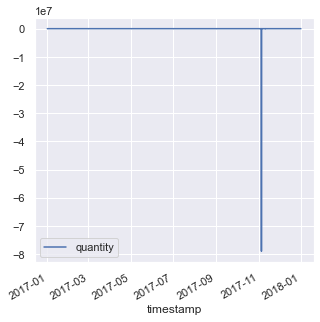

In [7]:
dev_2017_pre.set_index('timestamp', inplace=True, drop=True)
dev_2017_pre.plot()

The outliers seem very scarce. A reasonable way to remove them is using *z-scores*. The z-score of a data point measures how far it lies from the mean value, relative to the standard deviation (dispersion of the data). Here we retain data points that lie within three standard deviations of the mean. This will also remove the three consecutive `NaN` values from above.

<AxesSubplot:xlabel='timestamp'>

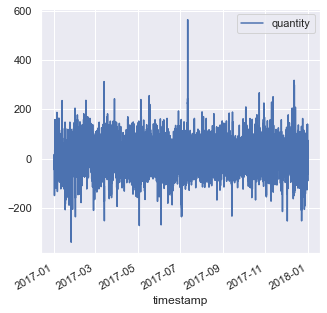

In [8]:
dev_2017 = dev_2017_pre.loc[(np.abs(stats.zscore(dev_2017_pre, nan_policy='omit'))<3)]
dev_2017.plot()

The new mean and minimum values in the dataframe that the outliers we removed were indeed very anomalous.

In [9]:
dev_2017.describe()

,quantity
count,17535.000000
mean,4.126121
std,58.231903
min,-340.750000
25%,-30.875000
50%,2.875000
75%,38.750000
max,565.125000


### Setting data resolution

The task requires to compare consumption and temperature deviations on a daily basis. This is reasonable, since a finer resolution of half-hourly records of consumption deviation has a large variability.

The next step is therefore to aggregate data on a daily basis, computing the mean deviation

In [10]:
dev_2017_daily = dev_2017.resample('D').mean()

Note that the dataframe obtained contains 365 rows, so it's complete. With the coarser resolution we have also addressed the issue of removed data (either for being `NaN` or for being outliers).

In [11]:
dev_2017_daily

,quantity
timestamp,
2017-01-01,-25.520833
2017-01-02,98.132812
2017-01-03,-36.273438
2017-01-04,34.421875
2017-01-05,25.817708
...,...
2017-12-27,-80.122396
2017-12-28,-33.854167
2017-12-29,5.757812


## Temperature data

For temperature records, we have at our disposal measurements from weather stations at airports in France. There are several stations scattered across France. 

Rather than restricting to one station, which only reflects temperature in one geographical site that may at best correlate with the local energy consumption, we will consider measurements from six stations which are geographically scattered (as determined 'by eye') and lie close to some of the most populated cities in France. 

The larger sample ensures that:
1. A temperature record be obtained that better reflects the geographic variability of temperature, which can be large.
2. The temperature measurements be associated with heavy energy consuming cities, which have a larger weight on the available mean energy consumption deviation in France

The weather stations chosen are:

- LFBO Toulousse
- LFLY Lyon
- LFML Marseille
- LFPB Paris
- LFRS Nantes
- LFQQ Lille

I will load data starting from year 2006, as more recent data tends to be more complete, and decide below which starting year encompasses more complete data while providing a solid historical record.

In [12]:
# Using index_col=['timestamp', 'station'] I adopt a hierarchical index,
# which makes it easier to categorize measurements by station

temperature_all_pre = pd.read_csv('asos_six_cities.txt', 
                                  sep=',', header=0, 
                                  names=['station', 'timestamp', 'temperature'], 
                                  parse_dates=['timestamp'], 
                                  index_col=['timestamp', 'station'])

In [13]:
temperature_all_pre.head(20)

temperature
timestamp           station             
2006-01-01 00:00:00 LFML             7.0
                    LFRS             3.0
                    LFBO             6.0
                    LFQQ             2.0
2006-01-01 00:30:00 LFBO             6.0
                    LFML             8.0
                    LFRS             3.0
2006-01-01 01:00:00 LFBO             6.0
                    LFML             8.0
                    LFRS             3.0
2006-01-01 01:30:00 LFRS             6.0
                    LFBO             6.0
                    LFML             8.0
2006-01-01 02:00:00 LFBO             6.0
                    LFRS             6.0
                    LFML             8.0
2006-01-01 02:30:00 LFML             8.0
                    LFBO             6.0
                    LFRS             6.0
2006-01-01 03:00:00 LFML             8.0

### Parsing data
At the moment we can't unstack the second level of the hierarchical index to have temperature measurements corresponding to one period in a single row. The reason is that the dataframe contains repeated indices (somehow pandas doesn't check for repetition when assigning an index while reading).

In [14]:
temperature_all_pre[temperature_all_pre.index.duplicated(keep=False)].head(50)

temperature
timestamp           station             
2006-03-26 22:00:00 LFPB            17.0
                    LFML            16.0
                    LFML            16.0
                    LFRS            13.0
                    LFQQ            14.0
                    LFQQ            14.0
                    LFBO            13.0
                    LFBO            13.0
                    LFRS            13.0
                    LFPB            17.0
2006-03-26 22:30:00 LFBO            13.0
                    LFBO            13.0
                    LFPB            17.0
                    LFPB            17.0
                    LFML            16.0
                    LFML            16.0
2006-05-30 22:00:00 LFML            14.0
                    LFQQ             6.0
                    LFML            14.0
                    LFQQ             6.0
2006-05-30 22:30:00 LFML            14.0
                    LFML            14.0
2006-05-30 23:30:00 LFML            13.0
                    LFML            13.0
2006-07-30 23:00:00 LFML            26.0
                    LFML            26.0
2006-07-30 23:30:00 LFML            26.0
                    LFML            26.0
2006-12-30 23:30:00 LFBO             7.0
                    LFBO             7.0
2007-03-25 22:00:00 LFML             6.0
                    LFRS             6.0
                    LFRS             6.0
                    LFLY             3.0
                    LFLY             3.0
                    LFPB             5.0
                    LFPB             5.0
                    LFBO             6.0
                    LFBO             6.0
                    LFML             6.0
2007-03-25 22:30:00 LFML             6.0
                    LFML             6.0
                    LFLY             3.0
                    LFBO             5.0
                    LFPB             4.0
                    LFBO             5.0
                    LFPB             4.0
                    LFLY             3.0
2007-05-30 22:30:00 LFPB            14.0
                    LFLY            14.0

Let's remove duplicate index entries

In [15]:
temperature_all_unique = temperature_all_pre[~temperature_all_pre.index.duplicated(keep='first')]

Now we try to assess what is a good starting year for our historical records.

In [16]:
temperature_all_stations_pre = temperature_all_unique.unstack()

In [17]:
temperature_all_stations_pre.head(60)

temperature                           
station                    LFBO LFLY  LFML LFPB LFQQ  LFRS
timestamp                                                 
2006-01-01 00:00:00         6.0  NaN   7.0  NaN  2.0   3.0
2006-01-01 00:30:00         6.0  NaN   8.0  NaN  NaN   3.0
2006-01-01 01:00:00         6.0  NaN   8.0  NaN  NaN   3.0
2006-01-01 01:30:00         6.0  NaN   8.0  NaN  NaN   6.0
2006-01-01 02:00:00         6.0  NaN   8.0  NaN  NaN   6.0
2006-01-01 02:30:00         6.0  NaN   8.0  NaN  NaN   6.0
2006-01-01 03:00:00         NaN  NaN   8.0  NaN  2.0   6.0
2006-01-01 03:30:00         6.0  NaN   8.0  NaN  NaN   NaN
2006-01-01 03:54:00         6.0  NaN   NaN  NaN  NaN   NaN
2006-01-01 04:00:00         NaN  NaN   8.0  NaN  2.0   8.0
2006-01-01 04:30:00         6.0  NaN   7.0  NaN  2.0   NaN
2006-01-01 05:00:00         6.0  3.0   6.0  NaN  2.0   8.0
2006-01-01 05:30:00         6.0  NaN   6.0  4.0  2.0   NaN
2006-01-01 06:00:00         6.0  2.0   5.0  4.0  3.0   9.0
2006-01-01 06:30:00         5.0  NaN   5.0  4.0  3.0   NaN
2006-01-01 07:00:00         5.0  2.0   NaN  5.0  3.0   9.0
2006-01-01 07:04:00         NaN  NaN   5.0  NaN  NaN   NaN
2006-01-01 07:30:00         5.0  NaN   4.0  5.0  3.0   NaN
2006-01-01 08:00:00         5.0  2.0   4.0  5.0  3.0   9.0
2006-01-01 08:30:00         6.0  NaN   4.0  6.0  3.0   NaN
2006-01-01 08:54:00         NaN  2.0   NaN  NaN  NaN   NaN
2006-01-01 09:00:00         6.0  NaN   4.0  6.0  3.0   9.0
2006-01-01 09:30:00         7.0  NaN   5.0  6.0  3.0   NaN
2006-01-01 10:00:00         8.0  4.0   6.0  6.0  3.0   9.0
2006-01-01 10:30:00         7.0  NaN   6.0  7.0  3.0   NaN
2006-01-01 11:00:00         8.0  7.0   8.0  7.0  3.0  10.0
2006-01-01 11:30:00         9.0  NaN   8.0  NaN  3.0   NaN
2006-01-01 12:00:00         NaN  7.0   9.0  8.0  3.0  10.0
2006-01-01 12:05:00         9.0  NaN   NaN  NaN  NaN   NaN
2006-01-01 12:30:00         9.0  NaN  10.0  8.0  3.0   NaN
2006-01-01 13:00:00         9.0  6.0  10.0  8.0  3.0   NaN
2006-01-01 13:11:00         NaN  NaN   NaN  NaN  NaN  10.0
2006-01-01 13:30:00         8.0  NaN  11.0  8.0  3.0   NaN
2006-01-01 14:00:00         9.0  5.0  10.0  8.0  3.0  10.0
2006-01-01 14:10:00         NaN  5.0   NaN  NaN  NaN   NaN
2006-01-01 14:30:00         9.0  NaN  10.0  8.0  3.0   NaN
2006-01-01 15:00:00         8.0  5.0  10.0  8.0  3.0   9.0
2006-01-01 15:30:00         7.0  NaN   9.0  8.0  4.0   NaN
2006-01-01 16:00:00         7.0  5.0   8.0  8.0  4.0   9.0
2006-01-01 16:30:00         7.0  NaN   7.0  7.0  4.0   NaN
2006-01-01 17:00:00         6.0  NaN   7.0  7.0  4.0   8.0
2006-01-01 17:30:00         7.0  NaN   6.0  7.0  4.0   NaN
2006-01-01 18:00:00         6.0  NaN   6.0  NaN  3.0   8.0
2006-01-01 18:30:00         6.0  NaN   6.0  NaN  4.0   NaN
2006-01-01 19:00:00         7.0  NaN   6.0  NaN  4.0   8.0
2006-01-01 19:30:00         7.0  NaN   6.0  NaN  4.0   NaN
2006-01-01 20:00:00         7.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 20:30:00         NaN  NaN   6.0  NaN  4.0   NaN
2006-01-01 20:35:00         7.0  NaN   NaN  NaN  NaN   NaN
2006-01-01 21:00:00         7.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 21:30:00         7.0  NaN   6.0  NaN  4.0   NaN
2006-01-01 22:00:00         7.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 22:30:00         7.0  NaN   6.0  NaN  NaN   NaN
2006-01-01 23:00:00         6.0  NaN   6.0  NaN  4.0   7.0
2006-01-01 23:30:00         6.0  NaN   6.0  NaN  NaN   NaN
2006-01-02 00:00:00         6.0  NaN   6.0  NaN  4.0   6.0
2006-01-02 00:30:00         6.0  NaN   5.0  NaN  NaN   6.0
2006-01-02 01:00:00         7.0  NaN   4.0  NaN  NaN   6.0
2006-01-02 01:30:00         7.0  NaN   4.0  NaN  NaN   5.0
2006-01-02 02:00:00         7.0  NaN   4.0  NaN  NaN   5.0

The table below shows the percentage of missing values among the different weather stations. Note that starting from 2012, records may be qualified as sufficiently complete, but this would leave a short range of historical measurements.

In [18]:
df = temperature_all_stations_pre
missing_value_df = pd.DataFrame({str(y): df[str(y)].isnull().sum() * 100 / len(df[str(y)]) for y in range(2006,2018)})
display(missing_value_df)

2006       2007       2008       2009       2010  \
            station                                                          
temperature LFBO     11.235721   8.479268   8.099439   6.964932   7.808307   
            LFLY     77.961504  36.115399  31.082598  29.772519  29.634002   
            LFML     10.734964   8.484590   7.623630   6.770411   7.636578   
            LFPB     12.425017   8.638952   8.110131   6.581294   7.663411   
            LFQQ     23.165197  14.462128  13.803796  12.573621  13.040678   
            LFRS     44.603829  43.040400  41.422080  42.475820  41.773103   

                          2011      2012      2013      2014      2015  \
            station                                                      
temperature LFBO      6.518898  3.636060  2.844236  2.795447  2.734919   
            LFLY     22.116327  3.524695  2.721544  2.884723  2.634657   
            LFML      6.731293  4.643911  3.892700  3.995090  3.626135   
            LFPB      5.571289  3.719583  3.998662  2.695012  2.801760   
            LFQQ     11.698072  8.157470  7.768669  7.214597  3.330920   
            LFRS     30.040301  4.877777  3.898277  3.771900  3.453462   

                         2016      2017  
            station                      
temperature LFBO     3.271292  1.894785  
            LFLY     2.566272  0.955979  
            LFML     2.363226  1.230752  
            LFPB     3.846588  1.728777  
            LFQQ     3.102087  2.610338  
            LFRS     2.413988  1.425382

Since we don't require the finest half-hourly resolution, let's adopt 2007 as starting year. 

In [19]:
starting_year = '2007'
temperature_all_stations = temperature_all_stations_pre[starting_year:]

The mean and median lie close to each other, so there are likely no outliers that might affect our analysis.

In [20]:
temperature_all_stations.describe() 

temperature                                               \
station           LFBO           LFLY           LFML           LFPB   
count    189844.000000  169534.000000  189494.000000  189795.000000   
mean         14.048213      12.951225      15.814802      12.071477   
std           7.558399       8.151020       7.634371       7.069095   
min         -12.000000     -12.000000      -9.000000     -12.000000   
25%           9.000000       7.000000      10.000000       7.000000   
50%          14.000000      13.000000      16.000000      12.000000   
75%          19.000000      19.000000      22.000000      17.000000   
max          40.000000      39.000000      39.000000      39.000000   

                                       
station           LFQQ           LFRS  
count    182000.000000  159416.000000  
mean         11.182549      12.410385  
std           6.766268       6.378766  
min         -13.000000      -8.000000  
25%           6.000000       8.000000  
50%          11.000000      12.000000  
75%          16.000000      17.000000  
max          35.000000      37.000000

### Setting data resolution

Here we will again opt for a daily resolution of temperature data. First we compute daily averages for each station.

In [21]:
temperature_stations_daily = temperature_all_stations.resample('D').mean()

In [22]:
temperature_stations_daily

temperature                                                       
station           LFBO       LFLY       LFML       LFPB       LFQQ       LFRS
timestamp                                                                    
2007-01-01    9.428571  10.777778  12.941176   8.885714   7.387097   9.166667
2007-01-02    8.833333   6.416667   9.854167   7.166667   6.522727   8.481481
2007-01-03    7.595745   6.750000   8.062500   7.541667   6.782609   7.724138
2007-01-04    8.361702   5.400000   6.804348   9.687500   9.697674  11.000000
2007-01-05   10.270833   6.909091  10.562500  10.391304   9.386364  10.810811
...                ...        ...        ...        ...        ...        ...
2017-12-26    7.791667   9.750000  11.791667   6.770833   6.125000   7.458333
2017-12-27    6.333333   7.020833   9.104167   5.250000   5.145833   5.541667
2017-12-28    4.979167   2.666667   5.812500   2.583333   1.958333   3.208333
2017-12-29    7.729167   1.458333   4.312500   4.187500   3.229167  10.187500
2017-12-30   12.625000   7.312500   8.229167  12.895833  10.750000  13.208333

[4017 rows x 6 columns]

Note that the last record corresponds to December 30 2017. Below we will fill the missing record for the last day of 2017 with the value of Dec. 30th (temperature seems to vary a lot around those days though). For the moment we just make sure the datetime index comprises all days in the period under consideration.

In [23]:
last_year = '2017'
complete_index = pd.date_range(start=starting_year+'-01-01', end=last_year+'-12-31', freq='D')
temperature_daily = temperature_stations_daily.reindex(complete_index)

At this point we check if there are incidentally a days for which no weather station has temperature measurements

In [24]:
temperature_daily[temperature_daily.isnull().any(axis=1)]

temperature                                                     
station           LFBO      LFLY       LFML      LFPB       LFQQ       LFRS
2008-03-28   10.520833       NaN  11.875000  6.276596   5.909091   9.659574
2012-07-15         NaN       NaN        NaN       NaN        NaN        NaN
2013-04-30   10.187500  12.37500  17.458333       NaN  10.000000   9.833333
2016-08-17   24.375000  24.06383  24.062500       NaN  20.354167  21.229167
2017-12-31         NaN       NaN        NaN       NaN        NaN        NaN

We fill those missing records with the last previous non-null value

In [25]:
temperature_daily.fillna(method='ffill', inplace=True)

Let us finally add columns containing the station-wide mean temperature and its standard deviation.

In [26]:
temperature_daily.columns = temperature_daily.columns.get_level_values(1)

temperature_daily['mean'] = temperature_daily.mean(axis=1)
temperature_daily['std'] = temperature_daily.std(axis=1)

In [48]:
temperature_daily

station,LFBO,LFLY,LFML,LFPB,LFQQ,LFRS,mean,std
2007-01-01,9.428571,10.777778,12.941176,8.885714,7.387097,9.166667,9.764501,1.732655
2007-01-02,8.833333,6.416667,9.854167,7.166667,6.522727,8.481481,7.879174,1.268880
2007-01-03,7.595745,6.750000,8.062500,7.541667,6.782609,7.724138,7.409443,0.483993
2007-01-04,8.361702,5.400000,6.804348,9.687500,9.697674,11.000000,8.491871,1.897303
2007-01-05,10.270833,6.909091,10.562500,10.391304,9.386364,10.810811,9.721817,1.333307
...,...,...,...,...,...,...,...,...
2017-12-27,6.333333,7.020833,9.104167,5.250000,5.145833,5.541667,6.399306,1.374443
2017-12-28,4.979167,2.666667,5.812500,2.583333,1.958333,3.208333,3.534722,1.385934
2017-12-29,7.729167,1.458333,4.312500,4.187500,3.229167,10.187500,5.184028,2.914543
2017-12-30,12.625000,7.312500,8.229167,12.895833,10.750000,13.208333,10.836806,2.319821


### Preparing dataframes for analysis

The last step of data preparation consists of creating a dataframe of daily mean temperatures for 2017 and one of daily historical mean temperatures. We start by defining the easier one.

In [49]:
temp_last_daily = temperature_daily.loc[last_year][['mean']]

To produce a dataframe with historical mean temperatures for each day of the year, we need to aggregate by day, regardless of year

In [50]:
next_to_last=str(int(last_year)-1)
temp_hist_daily_pre = temperature_daily[:next_to_last][['mean']] 
temp_hist_daily_pre['time_of_year'] = temp_hist_daily_pre.index.strftime('%m-%d %H:%M:%S')

temp_hist_daily_leap = temp_hist_daily_pre.groupby('time_of_year').mean()

The resulting dataframe will contain one row corresponding to the leap day February 29th. Since 2017 is not leap, we remove it to obtain compatible dataframes

In [51]:
if temp_last_daily.index.is_leap_year.all(): 
    temp_hist_daily = temp_hist_daily_leap    
else: temp_hist_daily = temp_hist_daily_leap[~temp_hist_daily_leap.index.str.contains('02-29', regex=False)]

After being grouped by `time_of_year`, the dataframe is indexed by a string. Since we would like to interpret it as a real timestamp that should be compared with the data for year 2017, we make a datetime index out of it.

In [53]:
temp_hist_daily['not_a_timestamp'] = pd.to_datetime(last_year+'-'+temp_hist_daily.index)

<ipython-input-53-2bdf23d60f32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_hist_daily['not_a_timestamp'] = pd.to_datetime(last_year+'-'+temp_hist_daily.index)


In [54]:
temp_hist_daily.set_index('not_a_timestamp', inplace=True, drop=True)

The obtained dataframe consists of reference historical mean values for every day of the year 2017.  Each value equals the average of the daily mean temperature on the given date over the historical record (from 2007 to 2016 in this case.

In [55]:
temp_hist_daily

station,mean
not_a_timestamp,
2017-01-01,6.173527
2017-01-02,5.669386
2017-01-03,5.660987
2017-01-04,5.923255
2017-01-05,5.737905
...,...
2017-12-27,5.430167
2017-12-28,5.242146
2017-12-29,5.570469


## Relating temperature deviations with consumption deviations

### Data preparation

Let's first gather the variables relevant for our analysis in a single dataframe. 

In [56]:
temperature_consumption = pd.concat([dev_2017_daily,
                                     temp_hist_daily,
                                     temp_last_daily], 
                                    axis=1,
                                    keys=['surplus',
                                          'temp_hist',
                                          'temp_'+str(last_year)])

# this is to make sure the column labels are those passed as keys in the concatenation
temperature_consumption.columns = temperature_consumption.columns.get_level_values(0)

temperature_consumption.index.name = 'timestamp'

We derive first the deviation of the mean daily temperature in 2017 from the historical mean temperature for the corresponding date.

In [57]:
temperature_consumption['temp_deviation'] = temperature_consumption['temp_2017']-temperature_consumption['temp_hist']

Since we are required to estimate the probability of deficit or surplus in the electrical grid, we add a corresponding categorical value to the dataframe. Its value is one if there is a surplus (or a perfect balance) and zero if there is a deficit.

In [58]:
def surplus(x): return int((np.sign(x)+1)/2)

# .astype('category') would yield a categorical type
temperature_consumption['surplus_cat'] = temperature_consumption['surplus'].map(surplus).astype('int')


In [59]:
temperature_consumption

,surplus,temp_hist,temp_2017,temp_deviation,surplus_cat
timestamp,,,,,
2017-01-01,-25.520833,6.173527,0.950534,-5.222992,0
2017-01-02,98.132812,5.669386,3.193579,-2.475806,1
2017-01-03,-36.273438,5.660987,1.580530,-4.080457,0
2017-01-04,34.421875,5.923255,2.662430,-3.260825,1
2017-01-05,25.817708,5.737905,3.032828,-2.705077,1
...,...,...,...,...,...
2017-12-27,-80.122396,5.430167,6.399306,0.969139,0
2017-12-28,-33.854167,5.242146,3.534722,-1.707423,0
2017-12-29,5.757812,5.570469,5.184028,-0.386442,1


Since we expect the relation between temperature and consumption deviations to be conditioned by the seasonal temperature, it is reasonable to categorize dates according to meteorological season before doing the analysis (any existing relation might be averaged out otherwise). Meteorological seasons differ from the astronomical seasons in that they begin with the month and exhibit the hottest (in summer) and the coldest (in winter) quarters of the year.

In [60]:
def get_season(timestamp):
    
    spring = range(3,6)
    summer = range(6,9)
    autumn = range(9,12)
        
    if timestamp.month in spring: return 'Spring'
    elif timestamp.month in summer: return 'Summer'
    elif timestamp.month in autumn: return 'Autumn'
    else: return 'Winter'

# season='winter'
# plt.scatter(temp_last_daily[temp_last_daily.index.map(get_season)==season]['deviation'], dev_2017_daily[dev_2017_daily.index.map(get_season)==season]['quantity'], s=5, marker='.')

temperature_consumption['season'] = temperature_consumption.index.map(get_season)

temperature_consumption_seasonal = {k: g for k, g in temperature_consumption.groupby('season')}

seasons = ['Winter', 'Spring', 'Summer', 'Autumn']

### Exploratory data analysis

To get an idea of what we may expect from our data, let us inspect some of its statistical properties. 

We start with seasonal scatter plots, that is, plots of the pairs (temp_deviation, surplus) for every day of 2017, that we enrich with histograms for the surplus and temperature deviation distributions, and a linear regression, to have an impression of the correlation between both variables.

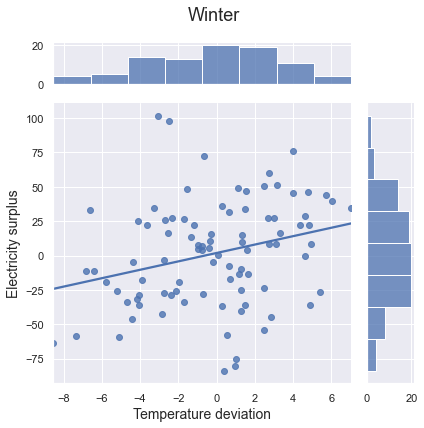

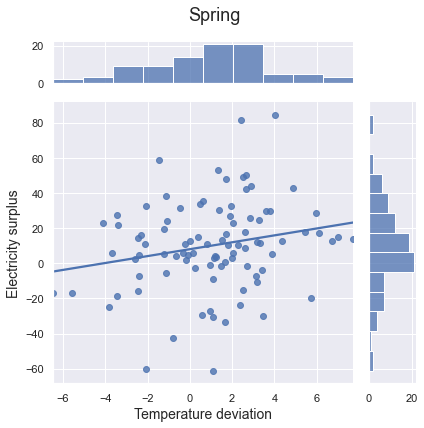

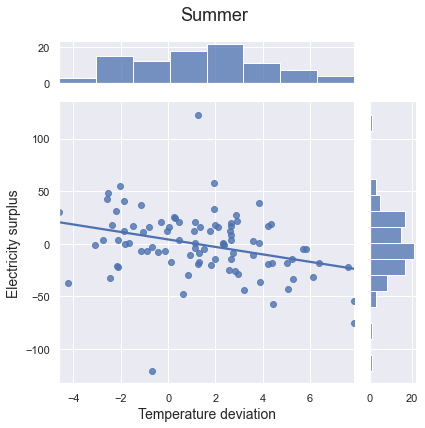

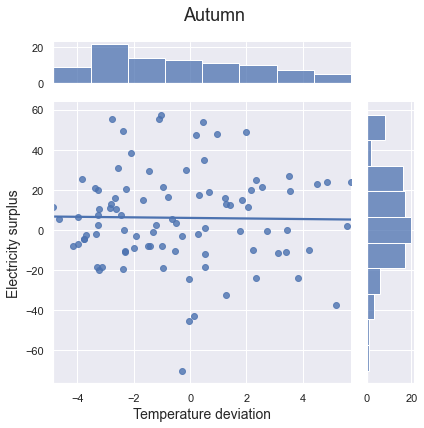

In [61]:
# unable to get jointplots as subplots
# fig, axs = plt.subplots(4, 1, figsize=(6, 6))


for season in seasons: 
    p = sns.jointplot(data=temperature_consumption_seasonal[season],
                  x='temp_deviation', y='surplus', kind='reg',
                  marginal_ticks=True, joint_kws=dict(ci=None),
                  marginal_kws=dict(kde=False))
    p.fig.suptitle(season, fontsize=18)
    p.fig.tight_layout()
    p.set_axis_labels('Temperature deviation', 'Electricity surplus', fontsize=14)






The (Pearson) correlation coefficient quantifies the extent to which a linear relation might possibly hold between temperature and consumption deviations. As suspected from the plots above, the values computed below confirm that a linear trend might hold at best for winter and summer data.

In [64]:
pd.DataFrame({'Season': [season for season in seasons],'Pearson correlation': [temperature_consumption_seasonal[season]['temp_deviation'].corr(temperature_consumption_seasonal[season]['surplus']) for season in seasons]})

,Season,Pearson correlation
0,Winter,0.273497
1,Spring,0.213786
2,Summer,-0.316538
3,Autumn,-0.015630


### Question

Can we say with a certain probability that we will have a surplus or a deficit in the grid depending on the temperature deviation?

#### Answer:

The task presented belongs to the class of statistical problems known as *classification problems*. Here, we aim to relate the possible outcomes of a **finite** variable to other *predictor* variables that we suspect may bear an influence on it. In our situation, the finite variable is `surplus_cat`: whether electricity consumption in France exhibited (on average) a surplus or deficit on a given day. The predictor variable we are currently accounting for is `temp_deviation`: by how much did the actual daily mean temperature on a given day in 2017 differed from the historical mean daily temperature on that day in previous years.

Statistical models to address classification problems provide an estimate of the probability for the outcomes of the finite variables (e.g. `surplus_cat`) given the values of the predictor variables (e.g. `temp_deviation`). In the present case, since the consumption deviation data covers only year 2017, it would only be a rough estimate, though. If we had earlier records at our disposal, it would be possible to benchmark the quality of the probability estimate against its performance on the historical records. 

On the other hand, we are considering only the possible effect of temperature deviations on consumption deviations. Ideally, further variables besides temperature deviations should be available, which could capture the statistical nature of consumption deviations more faithfully and give us room (dimensions) to carry out a finer analysis.

With that said, given the limited data, it is appropriate to favor simple models over more complicated ones, which more strongly rely on a richer availability of data (such as machine learning models).

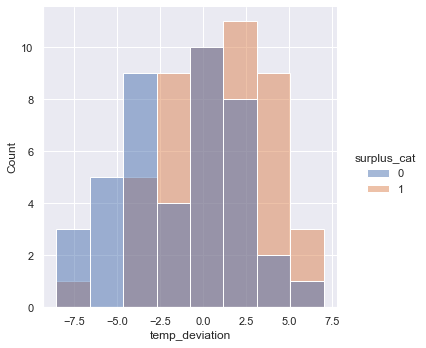

In [68]:
sns.displot(temperature_consumption_seasonal['Winter'], x='temp_deviation', hue='surplus_cat')

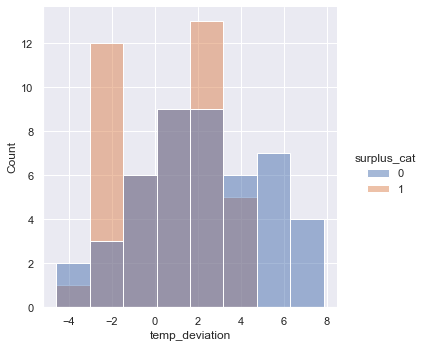

In [70]:
sns.displot(temperature_consumption_seasonal['Summer'], x='temp_deviation', hue='surplus_cat')

### Logistic regression

In logistic regression, a specific functional dependence of the probability of outcomes on the predictor variables is assumed (the *log-odds* depend linearly on the predictor variables), and the parameters of the functional dependence are optimized to provide the best fit possible given the data at hand (e.g. using maximum likelihood estimation). Logistic regression is a well known method for classification problems, and is implemented in many libraries.

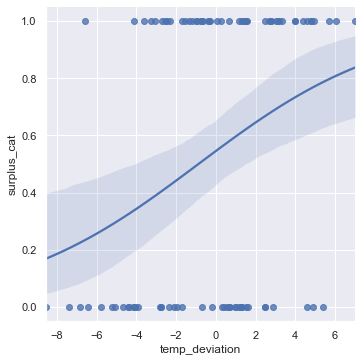

In [65]:
sns.lmplot(data=temperature_consumption_seasonal['Winter'], x='temp_deviation', y='surplus_cat', logistic=True)

### Linear discriminant analysis (LDA)